# Classification III –   Homework

**Overview**
- [Kaggle - Microsoft Malware Prediction](https://www.kaggle.com/c/microsoft-malware-prediction)
- Type: binary classification
- Metric: ROCAUC
- Achieved score: 0.68

In [9]:
import gc
import hashlib
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from category_encoders.ordinal import OrdinalEncoder
import lightgbm as lgbm
from lightgbm import LGBMClassifier

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold
)
from sklearn.pipeline import Pipeline

from IPython.display import display

warnings.filterwarnings("ignore")
sns.set()
%matplotlib inline

### Writing utility code for data preprocessing

Let's start with frequency encoder to use with high-cardinality features. The thing is simple enough, but I couldn't find a decent existing solution implemented as an estimator class for `scikit-learn`. So here comes our own:

In [2]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols, verbose=True):
        self.cols = cols
        self.mappings = {}
        self.verbose = verbose

    def fit(self, X, y=None):
        for col in self.cols:
            if self.verbose:
                print('Fitting frequency-encoded column: %s' % col)
            self.mappings[col] = X[col].value_counts().to_dict()
        return self

    def transform(self, X):
        for col in self.cols:
            if self.verbose:
                print('Transforming frequency-encoded column: %s' % col)
            X[col] = X[col].map(lambda x: self.mappings[col].get(x, np.nan)).astype('float32')
        return X
    
def test_frequency_encoder():
    df1 = pd.DataFrame({
        'a': ['a', 'b', 'b', 'c', 'c', 'c', np.nan],
    })
    df2 = pd.DataFrame({
        'a': ['a', 'd'],
    })
    encoder = FrequencyEncoder(cols=['a'], verbose=False)
    result1 = encoder.fit_transform(df1)
    result2 = encoder.transform(df2)
    expected1 = pd.DataFrame({
        'a': [1.0, 2.0, 2.0, 3.0, 3.0, 3.0, np.nan],
    }, dtype='float32')
    expected2 = pd.DataFrame({
        'a': [1.0, np.nan],
    }, dtype='float32')

    assert result1.equals(expected1)
    assert result2.equals(expected2)

test_frequency_encoder()

Next comes the encoder to split integer bit fields into individual bit columns. `BinaryEncoder` from `categorical_encoders` package doesn't fit our needs as it only treats source column as a integer-labeled categorical data, not an integer itself.

In [3]:
class BitFieldEncoder(BaseEstimator, TransformerMixin):
    """
    Explode bit field column into boolean columns for individual bits.
    Warning: it works for positive integers only.
    """
    def __init__(self, cols, verbose=True):
        self.cols = cols
        self.cols_bit_lengths = {}
        self.verbose = verbose

    @staticmethod
    def _bit_array(n, num_bits):
        if np.isnan(n):
            return np.nan
        return np.binary_repr(int(n), width=num_bits)
    
    def _fit_col(self, col, X, y=None):
        self.cols_bit_lengths[col] = int(X[col].max()).bit_length()

    def _transform_col(self, col, X):
        X[col] = X[col].map(lambda x: self._bit_array(x, self.cols_bit_lengths[col]))
        for bit in range(self.cols_bit_lengths[col]):
            # 'int' type does not understand NaNs, that's why 'float16' here
            X['%s_%d' % (col, bit)] = X[col].map(lambda x: x[-bit-1] if isinstance(x, str) else np.nan).astype('float16')
        X.drop([col], inplace=True, axis=1)

    
    def fit(self, X, y=None):
        """ Find the actual number of required bits by finding max value for each column. """
        for col in self.cols:
            if self.verbose:
                print('Fitting bit field column: %s' % col)
            self._fit_col(col, X, y)
        return self

    def transform(self, X):
        for col in self.cols:
            if self.verbose:
                print('Transforming bit field column: %s' % col)
            self._transform_col(col, X)
        return X


def test_bitfield_encoder():
    df1 = pd.DataFrame({
        'a': [2, 1, 3, 0, 8, np.nan],
    })
    df2 = pd.DataFrame({
        'a': [128],
    })

    encoder = BitFieldEncoder(cols=['a'], verbose=False)
    result1 = encoder.fit_transform(df1)
    result2 = encoder.transform(df2)
    expected1 = pd.DataFrame({
        'a_0': [0.0, 1.0, 1.0, 0.0, 0.0, np.nan],
        'a_1': [1.0, 0.0, 1.0, 0.0, 0.0, np.nan],
        'a_2': [0.0, 0.0, 0.0, 0.0, 0.0, np.nan],
        'a_3': [0.0, 0.0, 0.0, 0.0, 1.0, np.nan],
    }, dtype='float16')
    expected2 = pd.DataFrame({
        'a_0': [0.0],
        'a_1': [0.0],
        'a_2': [0.0],
        'a_3': [0.0],
    }, dtype='float16')
    
    assert result1.equals(expected1)
    assert result2.equals(expected2)

test_bitfield_encoder()

Now comes the monstrous class to encode version strings by transforming it into three columns (categorical major/minor versions and overall integer ordering). The code could be much simplier, but the attempt to make the code "reusable" by covering all the corner cases eventually ended up with this.

In [4]:
class VersionEncoder(BaseEstimator, TransformerMixin):
    """
    Split version into two categorical (major, minor) and overall ordering column.
    
    A little bit of a mess here.
    """
    def __init__(self, cols, col_segment_lengths=None, verbose=True):
        self.cols = cols
        self.verbose = verbose

        if col_segment_lengths:
            self.cols_segment_lengths = col_segment_lengths
        else:
            self.cols_segment_lengths = {}

    def fit_col(self, col, X, y=None):
        if col in self.cols_segment_lengths:
            return
        values = X[col].dropna().astype(str).map(lambda x: x.split('.'))
        num_segments = values.map(len).max()

        self.cols_segment_lengths[col] = []
        for seg_num in range(num_segments):
            seg_length = values.map(lambda x: 0 if seg_num >= len(x) else len(x[seg_num])).max()
            self.cols_segment_lengths[col].append(seg_length)
        
    def transform_col(self, col, X):
        X[col] = X[col].astype(str).map(lambda x: np.nan if x == 'nan' else x.split('.'))
        X[col + '_maj'] = X[col].map(lambda x: x[0] if isinstance(x, list) else np.nan).astype('object')
        X[col + '_min'] = X[col].map(lambda x: '.'.join(x[:2]) if isinstance(x, list) else np.nan).astype('object')

        num_segments = len(self.cols_segment_lengths[col])

        # truncate
        X[col] = X[col].map(lambda x: x[:num_segments] if isinstance(x, list) else np.nan)
        # pad
        X[col] = X[col].map(lambda x: x + ['0'] * (num_segments - len(x)) if isinstance(x, list) else np.nan)

        for seg_num in range(num_segments):
            segment_len = self.cols_segment_lengths[col][seg_num]
            def _zfill_segment(arr):
                if not isinstance(arr, list):
                    return np.nan
                if len(arr[seg_num]) > segment_len:
                    raise ValueError('Length of segment #%d in %s exceeds the one learned during fitting column `%s`.\n'
                                     'Please manually provide `col_segment_lengths` parameter to __init__ to mitigate this.\n'
                                     'For version strings like "1.20.300.400" it would be:\n'
                                     '`VersionEncoder(cols=["%s"], col_segment_lengths={"%s": [1, 2, 3, 4]})`\n'
                                     % (seg_num, arr, col, col, col))
                arr[seg_num] = arr[seg_num].zfill(segment_len)
                return arr
            X[col].map(_zfill_segment)

        def _to_ord(x):
            try:
                return int(''.join(x))
            except (TypeError, ValueError):
                return np.nan

        X[col + '_ord'] = X[col].map(_to_ord).astype('float64')
        X.drop([col], inplace=True, axis=1)
        gc.collect()

    def fit(self, X, y=None):
        """ Determine the number and the lengths of dot-separated segments. """
        for col in self.cols:
            if self.verbose:
                print('Fitting version column: %s' % col)
            self.fit_col(col, X, y)
        return self

    def transform(self, X):
        for col in self.cols:
            if self.verbose:
                print('Transforming version column: %s' % col)
            self.transform_col(col, X)
        return X

    
def test_version_encoder():
    df1 = pd.DataFrame({
        'a': ['1.1.9', '1.20.9', '1.3.8', '2', np.nan],
    }, dtype='category')

    encoder = VersionEncoder(cols=['a'], verbose=False)
    result1 = encoder.fit_transform(df1)
    expected1 = pd.DataFrame({
        'a_maj': ['1', '1', '1', '2', np.nan],
        'a_min': ['1.1', '1.20', '1.3', '2', np.nan],
        'a_ord': [1019.0, 1209.0, 1038.0, 2000.0, np.nan],
    })

    assert result1.equals(expected1)
    
test_version_encoder()

Another thing we'll need is hashing encoder as cardinality reducer. `HashingEncoder` from `categorical_encoders` doesn't fit our needs as it applies one-hot encoding after hashing (we don't need one-hot with LightGBM). The code is pretty straightforward.

In [12]:
class HashEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols, cardinality=10000, verbose=True):
        self.cols = cols
        self.verbose = verbose
        self.cardinality = cardinality

    @staticmethod
    def _hash_int(x):
        return int(hashlib.md5(str(x).encode('utf-8')).hexdigest(), 16)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for col in self.cols:
            if self.verbose:
                print('Transforming hash-encoded column: %s' % col)
            X[col] = X[col].map(
                lambda x: np.nan if pd.isnull(x) else self._hash_int(x) % self.cardinality
            ).astype('float32')
        return X


def test_hash_encoder():
    df1 = pd.DataFrame({
        'a': ['a', 'b', 'b', 'c', 'c', 'c', np.nan],
    })
    encoder = HashEncoder(cols=['a'], verbose=False)
    result = encoder.fit_transform(df1)

    expected = pd.DataFrame({
        'a': [6497.0, 5343.0, 5343.0, 3443.0, 3443.0, 3443.0, np.nan],
    }, dtype='float32')
    
    assert result.equals(expected)

test_hash_encoder()

### Loading the data

Now let's load the dataset. Train/test splitting is already done and we will not change it. Positive/negative class balance is perfect as well.

Original training set size is 5.5 Gb which is a little bit too much. To minimize memory usage we manually adjust `dtypes`:
- load objects as `category`
- load binary values as `float16` if nans are present and `int8` otherwise
- switch 64 bits encoding to 32 or 16 (if possible)

EDA part is intentionally skipped here. Trivial column statistics can be found in existing Kaggle kernels for this competition. We could pay closer attention, of course, but we could take a look at feature importances first.

In [13]:
DATASET_DIR = 'D:/datasets/mmpc'
NROWS = 1000000    # number of rows to read

dtypes = {
    'MachineIdentifier':                                    'category',
    'ProductName':                                          'category',
    'EngineVersion':                                        'category',
    'AppVersion':                                           'category',
    'AvSigVersion':                                         'category',
    'IsBeta':                                               'int8',
    'RtpStateBitfield':                                     'float16',
    'IsSxsPassiveMode':                                     'int8',
    'DefaultBrowsersIdentifier':                            'float16',
    'AVProductStatesIdentifier':                            'float32',
    'AVProductsInstalled':                                  'float16',
    'AVProductsEnabled':                                    'float16',
    'HasTpm':                                               'int8',
    'CountryIdentifier':                                    'int16',
    'CityIdentifier':                                       'float32',
    'OrganizationIdentifier':                               'float16',
    'GeoNameIdentifier':                                    'float16',
    'LocaleEnglishNameIdentifier':                          'int8',
    'Platform':                                             'category',
    'Processor':                                            'category',
    'OsVer':                                                'category',
    'OsBuild':                                              'int16',
    'OsSuite':                                              'int16',
    'OsPlatformSubRelease':                                 'category',
    'OsBuildLab':                                           'category',
    'SkuEdition':                                           'category',
    'IsProtected':                                          'float16',
    'AutoSampleOptIn':                                      'int8',
    'PuaMode':                                              'category',
    'SMode':                                                'float16',
    'IeVerIdentifier':                                      'float16',
    'SmartScreen':                                          'category',
    'Firewall':                                             'float16',
    'UacLuaenable':                                         'float32',
    'Census_MDC2FormFactor':                                'category',
    'Census_DeviceFamily':                                  'category',
    'Census_OEMNameIdentifier':                             'float16',
    'Census_OEMModelIdentifier':                            'float32',
    'Census_ProcessorCoreCount':                            'float16',
    'Census_ProcessorManufacturerIdentifier':               'float16',
    'Census_ProcessorModelIdentifier':                      'float16',
    'Census_ProcessorClass':                                'category',
    'Census_PrimaryDiskTotalCapacity':                      'float32',
    'Census_PrimaryDiskTypeName':                           'category',
    'Census_SystemVolumeTotalCapacity':                     'float32',
    'Census_HasOpticalDiskDrive':                           'int8',
    'Census_TotalPhysicalRAM':                              'float32',
    'Census_ChassisTypeName':                               'category',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
    'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
    'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
    'Census_PowerPlatformRoleName':                         'category',
    'Census_InternalBatteryType':                           'category',
    'Census_InternalBatteryNumberOfCharges':                'float32',
    'Census_OSVersion':                                     'category',
    'Census_OSArchitecture':                                'category',
    'Census_OSBranch':                                      'category',
    'Census_OSBuildNumber':                                 'int16',
    'Census_OSBuildRevision':                               'int32',
    'Census_OSEdition':                                     'category',
    'Census_OSSkuName':                                     'category',
    'Census_OSInstallTypeName':                             'category',
    'Census_OSInstallLanguageIdentifier':                   'float16',
    'Census_OSUILocaleIdentifier':                          'int16',
    'Census_OSWUAutoUpdateOptionsName':                     'category',
    'Census_IsPortableOperatingSystem':                     'int8',
    'Census_GenuineStateName':                              'category',
    'Census_ActivationChannel':                             'category',
    'Census_IsFlightingInternal':                           'float16',
    'Census_IsFlightsDisabled':                             'float16',
    'Census_FlightRing':                                    'category',
    'Census_ThresholdOptIn':                                'float16',
    'Census_FirmwareManufacturerIdentifier':                'float16',
    'Census_FirmwareVersionIdentifier':                     'float32',
    'Census_IsSecureBootEnabled':                           'int8',
    'Census_IsWIMBootEnabled':                              'float16',
    'Census_IsVirtualDevice':                               'float16',
    'Census_IsTouchEnabled':                                'int8',
    'Census_IsPenCapable':                                  'int8',
    'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
    'Wdft_IsGamer':                                         'float16',
    'Wdft_RegionIdentifier':                                'float16',
    'HasDetections':                                        'int8'
}

gc.collect()
df = pd.read_csv(os.path.join(DATASET_DIR, 'train.csv'), dtype=dtypes, nrows=NROWS)

Now let's build `Pipeline` object for data preprocessing. Things done here:
- drop uninformative and redundant features (to speed things up)
- encode low- and medium-cardinality categoricals with integer labels (as required by LightGBM which does not need one-hot encodings)
- encode high-cardinality categoricals with `FrequencyEncoder`
- encode versions with custom `VersionEncoder`, bit fields with `BitFieldEncoder`
- apply some naive feature engineering (spoiler: in the end it won't help much anyway but let's still include example code)

NOTE: `scikit-learn` won't call `transform` on the last step of the pipe because it is meant to be an actual model. Last step "identity" transformer is actually a workaround for this.

In [14]:
DROP_COLUMNS = [
    'Census_ProcessorClass', 'IsBeta', 'HasTpm', 'Platform',
    'AutoSampleOptIn', 'ProductName', 'PuaMode', 'MachineIdentifier',
    
    'Census_OSBuildNumber', 'Census_OSBuildRevision',  # present in 'Census_OSVersion'
    'OsVer', 'OsBuild',   # captured in Census_OSVersion, differences don't correlate with target
    'OsBuildLab',   # captured in other featurs
]

VERSION_COLUMNS = [
    'AppVersion',
    'AvSigVersion',
    'Census_OSVersion',
]

HIGH_CARDINALITY_COLUMNS = [
    'Census_OEMModelIdentifier',
    'CityIdentifier',
    'Census_FirmwareVersionIdentifier',
    'AVProductStatesIdentifier',
]

NUMERIC_COLUMNS = [
    'AVProductsInstalled',
    'AVProductsEnabled',
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges',
]

NUMERIC_COLUMNS += [col + '_ord' for col in VERSION_COLUMNS]

BINARY_COLUMNS = [col for col in df.columns if df[col].nunique() == 2]

CATEGORICAL_COLUMNS = [
    col
    for col in df.columns
    if col not in DROP_COLUMNS
    and col not in NUMERIC_COLUMNS
    and col not in VERSION_COLUMNS
    and col not in BINARY_COLUMNS
    and col not in HIGH_CARDINALITY_COLUMNS
    and col != 'RtpStateBitfield'
]

CATEGORICAL_COLUMNS += [col + '_maj' for col in VERSION_COLUMNS]
CATEGORICAL_COLUMNS += [col + '_min' for col in VERSION_COLUMNS]

def convert_battery(x):
    return np.nan if pd.isnull(x) else int('li' in x.lower())

def convert_engineversion(x):
    return np.nan if pd.isnull(x) else int(x.split('.')[2])

def preprocess(X):
    print('Dropping columns...')
    X.drop(DROP_COLUMNS, inplace=True, axis=1)
    gc.collect()
    
    for col in CATEGORICAL_COLUMNS:
        if col in X.columns and X[col].dtype.name == 'category':
            X[col] = X[col].astype(str)
    
    print('Additional feature engineering...')
    X['Census_InternalBatteryType'] = X['Census_InternalBatteryType'].map(convert_battery).astype('float16')
    X['EngineVersion'] = X['EngineVersion'].apply(convert_engineversion).astype('float32')
    # Memory per CPU core
    X['ram_per_core'] = X.Census_TotalPhysicalRAM / X.Census_ProcessorCoreCount
    # Memory to disk space ratio
    X['ram_to_disk_capacity'] = X.Census_TotalPhysicalRAM / X.Census_PrimaryDiskTotalCapacity
    # Space on system partition to total space on disk
    X['system_volume_to_disk_capacity'] = X.Census_SystemVolumeTotalCapacity / X.Census_PrimaryDiskTotalCapacity

    return X

def identity(X):
    return X
    
pipe = Pipeline(steps=[
    ('preproc', FunctionTransformer(func=preprocess, validate=False)),
    ('bitfield', BitFieldEncoder(cols=['RtpStateBitfield'])),
    ('versions', VersionEncoder(cols=VERSION_COLUMNS)),
    ('freq', FrequencyEncoder(cols=HIGH_CARDINALITY_COLUMNS)),
    ('ordinal', OrdinalEncoder(cols=CATEGORICAL_COLUMNS)),
    ('last', FunctionTransformer(func=identity, validate=False)),    # required workaround, last step is meant to be some "model"
])

df = pipe.fit_transform(df)

Dropping columns...
Additional feature engineering...
Fitting bit field column: RtpStateBitfield
Transforming bit field column: RtpStateBitfield
Fitting version column: AppVersion
Fitting version column: AvSigVersion
Fitting version column: Census_OSVersion
Transforming version column: AppVersion
Transforming version column: AvSigVersion
Transforming version column: Census_OSVersion
Fitting frequency-encoded column: Census_OEMModelIdentifier
Fitting frequency-encoded column: CityIdentifier
Fitting frequency-encoded column: Census_FirmwareVersionIdentifier
Fitting frequency-encoded column: AVProductStatesIdentifier
Transforming frequency-encoded column: Census_OEMModelIdentifier
Transforming frequency-encoded column: CityIdentifier
Transforming frequency-encoded column: Census_FirmwareVersionIdentifier
Transforming frequency-encoded column: AVProductStatesIdentifier


### Parameter tuning and cross-validation

The dataset is quite large, only a sample of data will be used for grid search.

Parameter search is best done manually and iteratively (searching all at once would be very exhausting). Below is the sample code to choose `reg_alpha` parameter. The code for other parameters is omitted.

Notes:
* LightGBM library has it's own `lightgbm.cv()` but how exactly it can be used is unclear. Instead we'll use `GridSearch` from `scikit-learn`.
* We do not tune `num_boost_round` here because tuning it on a subset of data does not make much sense. Number of boosting iterations to fit the entirety of data will be much higher anyway. We will handle it later with `early_stopping`.

In [15]:
df_train = df.sample(frac=0.1)

train_target = df_train['HasDetections']
del df_train['HasDetections']
gc.collect();

params = {
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.04,
    'num_leaves': 68,
    'max_depth': 7,
    'colsample_bytree': 0.85,
    'subsample': 0.85,
    'min_data_in_leaf': 80,
}

grid_params = {
    'reg_alpha' : [0.1, 0.2],
}

clf = LGBMClassifier(n_jobs=3, **params)
grid = GridSearchCV(clf, grid_params, cv=5, n_jobs=4)
%time grid.fit(df_train, train_target, categorical_feature=CATEGORICAL_COLUMNS)
print('Best parameters:', grid.best_params_)
print('Best score:', grid.best_score_)

Wall time: 17 s
Best parameters: {'reg_alpha': 0.1}
Best score: 0.63688


### Training the model

Having done parameter tuning we will use obtained values to train our model on the entire dataset. Still we reserve a small validation set to use `early_stopping`.

*Actual number of trees on the entirety of the data would be around 3000.*

In [16]:
df_train, df_cv = train_test_split(df, test_size=0.1, stratify=df.HasDetections)

def create_dataset(df):
    target = df['HasDetections']
    del df['HasDetections']
    
    return lgbm.Dataset(
        df, label=target,
        feature_name=list(df_train.columns),
        categorical_feature=CATEGORICAL_COLUMNS,
        free_raw_data=False
    )

train_dataset = create_dataset(df_train)
cv_dataset = create_dataset(df_cv)

del df_train, df_cv; gc.collect();

In [17]:
params = {
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.04,
    'num_leaves': 68,
    'max_depth': 7,
    'colsample_bytree': 0.85,
    'subsample': 0.85,
    'min_data_in_leaf': 80,
    'reg_alpha': 0.1,
    'verbosity': -1,
}

# This kwargs are placed outside just because '%time' magic in IPython doesn't work with multiline sentences.
kwargs = {
    'num_boost_round': 4000,
    'early_stopping_rounds': 20,
    'valid_sets': [train_dataset, cv_dataset],
    'verbose_eval': False,
}

%time model = lgbm.train(params, train_dataset, **kwargs)
_ = model.save_model('model.txt')

Wall time: 2min 39s


In [18]:
print('Best iteration:', model.best_iteration)
print('Train score:', model.best_score['training']['auc'])
print('Validation score:', model.best_score['valid_1']['auc'])

Best iteration: 782
Train score: 0.7821903962273666
Validation score: 0.7218849956401934


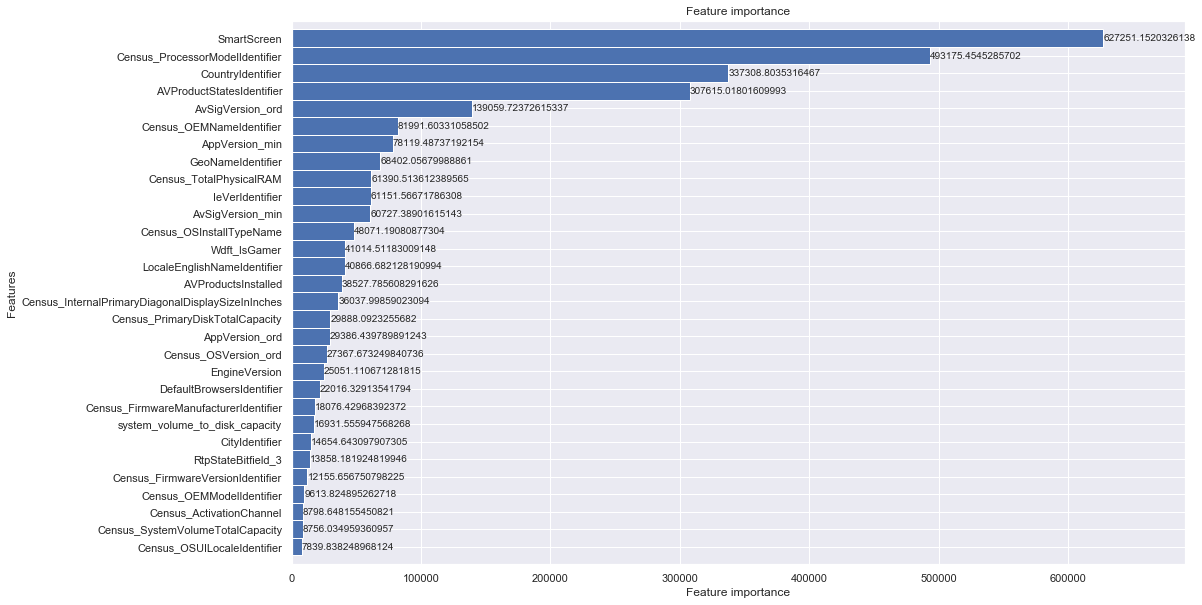

In [19]:
_ = lgbm.plot_importance(model, importance_type='gain', max_num_features=30, height=1, figsize=(16, 10))

### Making submission file

In [20]:
df_test = pd.read_csv(os.path.join(DATASET_DIR, 'test.csv'), dtype=dtypes)
test_id = df_test.MachineIdentifier  # Save machine ids for submission

# `OrdinalEncoder` won't transform dataframe having fewer dimensions than
# the one it was fitted on. So there's a little workaround.
df_test['HasDetections'] = '?'    
df_test = pipe.transform(df_test)
del df_test['HasDetections']

%time predictions = model.predict(df_test)

sub_df = pd.DataFrame({"MachineIdentifier": test_id.values})
sub_df["HasDetections"] = predictions
sub_df.to_csv("submit.csv", index=False)
sub_df[:5]

Dropping columns...
Additional feature engineering...
Transforming bit field column: RtpStateBitfield
Transforming version column: AppVersion
Transforming version column: AvSigVersion
Transforming version column: Census_OSVersion
Transforming frequency-encoded column: Census_OEMModelIdentifier
Transforming frequency-encoded column: CityIdentifier
Transforming frequency-encoded column: Census_FirmwareVersionIdentifier
Transforming frequency-encoded column: AVProductStatesIdentifier
Wall time: 5min 14s


,MachineIdentifier,HasDetections
0,0000010489e3af074adeac69c53e555e,0.501087
1,00000176ac758d54827acd545b6315a5,0.470941
2,0000019dcefc128c2d4387c1273dae1d,0.347842
3,0000055553dc51b1295785415f1a224d,0.301183
4,00000574cefffeca83ec8adf9285b2bf,0.473367


### Stacking ensemble

Now for the sake of exercise we will try to modify preprocessing pipeline and train another model. Then we will put both models in a stacked ensemble.

Thing to mention here:
- Our second model will use `HashEncoder` for high-cardinality and version columns. That's the difference. Boosting parameters will not be modified.
- Parameter searches are not performed here (they are extremely time consuming and annoying). Still the stacking itself is done with proper out-of-fold method.
- The code is self-duplicated and messy. Though we could find external libraries to do the same thing (e.g. `vecstack`), they tend to be usable in only the simpliest cases. For example, they do not allow to pass arbitrary parameters to `fit` method of individual estimators. One solution to this problem would be to write thin class wrapper around our estimator but let's rather write the whole thing from scratch. The code below is loosely based on examples provided in documentation for `vecstack`: https://github.com/vecxoz/vecstack/blob/master/examples/00_stacking_concept_pictures_code.ipynb

**Actually this ensemble does not provide any improvement to the score.**

First, let's create our meta datasets and define the splits.

In [21]:
train_meta = df.copy()
test_meta = df_test.copy()

kfold = StratifiedKFold(n_splits=3, shuffle=False, random_state=0)
folds = list(kfold.split(df, df['HasDetections']))

scores = {}

Re-train the first model and make out-of-fold predictions:

In [22]:
df_train = df.copy()
train_target = df_train['HasDetections']
del df_train['HasDetections']
gc.collect();

clf = LGBMClassifier(n_jobs=3, **params)

for fold_counter, (train_index, test_index) in enumerate(folds):
    
    # Split data and target
    X_tr = df_train.loc[train_index]
    y_tr = train_target[train_index]
    X_te = df_train.loc[test_index]
    y_te = train_target[test_index]
    
    # Fit the fold
    clf.fit(X_tr, y_tr, categorical_feature=CATEGORICAL_COLUMNS)
    # Predict out-of-fold part of train set
    train_meta.loc[test_index, 'm1'] = clf.predict_proba(X_te)[:, 1]

# Calculate OOF score
scores['m1'] = roc_auc_score(train_target, train_meta['m1'])
    
# Fit on full train set and predict test set once
_ = clf.fit(df_train, train_target)
test_meta['m1'] = clf.predict_proba(df_test)[:, 1]

Apply modified preprocessing scheme:

In [27]:
df = pd.read_csv(os.path.join(DATASET_DIR, 'train.csv'), dtype=dtypes, nrows=NROWS)
gc.collect()

CATEGORICAL_COLUMNS_2 = CATEGORICAL_COLUMNS + HIGH_CARDINALITY_COLUMNS + VERSION_COLUMNS
for col in VERSION_COLUMNS:
    CATEGORICAL_COLUMNS_2.remove(col + '_maj')
    CATEGORICAL_COLUMNS_2.remove(col + '_min')

pipe = Pipeline(steps=[
    ('preproc', FunctionTransformer(func=preprocess, validate=False)),
    ('bitfield', BitFieldEncoder(cols=['RtpStateBitfield'])),
    ('versions', HashEncoder(cols=VERSION_COLUMNS)),
    ('hash', HashEncoder(cols=HIGH_CARDINALITY_COLUMNS)),
    ('ordinal', OrdinalEncoder(cols=CATEGORICAL_COLUMNS_2)),
    ('last', FunctionTransformer(func=identity, validate=False)),    # required workaround, last step is meant to be some "model"
])

df = pipe.fit_transform(df)

df_test = pd.read_csv(os.path.join(DATASET_DIR, 'test.csv'), dtype=dtypes)
df_test['HasDetections'] = '?'    
df_test = pipe.transform(df_test)
del df_test['HasDetections']

Dropping columns...
Additional feature engineering...
Fitting bit field column: RtpStateBitfield
Transforming bit field column: RtpStateBitfield
Transforming hash-encoded column: AppVersion
Transforming hash-encoded column: AvSigVersion
Transforming hash-encoded column: Census_OSVersion
Transforming hash-encoded column: Census_OEMModelIdentifier
Transforming hash-encoded column: CityIdentifier
Transforming hash-encoded column: Census_FirmwareVersionIdentifier
Transforming hash-encoded column: AVProductStatesIdentifier
Dropping columns...
Additional feature engineering...
Transforming bit field column: RtpStateBitfield
Transforming hash-encoded column: AppVersion
Transforming hash-encoded column: AvSigVersion
Transforming hash-encoded column: Census_OSVersion
Transforming hash-encoded column: Census_OEMModelIdentifier
Transforming hash-encoded column: CityIdentifier
Transforming hash-encoded column: Census_FirmwareVersionIdentifier
Transforming hash-encoded column: AVProductStatesIdenti

 Train the second model and make out-of-fold predictions:

In [28]:
df_train = df.copy()
train_target = df_train['HasDetections']
del df_train['HasDetections']
gc.collect();

clf = LGBMClassifier(n_jobs=3, **params)

# Loop across folds
for fold_counter, (train_index, test_index) in enumerate(folds):
    
    # Split data and target
    X_tr = df_train.loc[train_index]
    y_tr = train_target[train_index]
    X_te = df_train.loc[test_index]
    y_te = train_target[test_index]
    
    # Fit
    clf.fit(X_tr, y_tr, categorical_feature=CATEGORICAL_COLUMNS_2)
    
    # Predict out-of-fold part of train set
    train_meta.loc[test_index, 'm2'] = clf.predict_proba(X_te)[:, 1]
    
# Calculate OOF score
scores['m2'] = roc_auc_score(train_target, train_meta['m2'])

# Fit on full train set and predict test set once
_ = clf.fit(df_train, train_target)
test_meta['m2'] = clf.predict_proba(df_test)[:, 1]

Let's take a look at the train set results for each of the classifiers:

In [29]:
print('Classifier 1 score:', scores['m1'])
print('Classifier 2 score:', scores['m2'])
pearson_corr = train_meta['m1'].corr(train_meta['m2'], method='pearson')
print('Pearson correlation between meta-features:', pearson_corr)

Classifier 1 score: 0.7080008851923318
Classifier 2 score: 0.7086535208876198
Pearson correlation between meta-features: 0.9619229533167336


Correlation is not very promising. Stacking is unlikely to help us very much in this case. But still let's train new model on both original and meta features. This time let's try random forest instead of gradient boosting.

In [30]:
forest_params = {
    'boosting_type': 'rf',
    'num_leaves': 165,
    'colsample_bytree': .5,
    'n_estimators': 400,
    'min_child_weight': 5,
    'min_child_samples': 10,
    'subsample': .632,
    'subsample_freq': 1,
    'min_split_gain': 0,
    'reg_alpha': 0,
    'reg_lambda': 5, # L2 regularization
    'n_jobs': 3,
}

df_train, df_cv = train_test_split(train_meta, test_size=0.2, stratify=train_meta.HasDetections)

train_target = df_train['HasDetections']
del df_train['HasDetections']
gc.collect();

clf = LGBMClassifier(**forest_params)
clf.fit(df_train, train_target, categorical_feature=CATEGORICAL_COLUMNS)

cv_target = df_cv['HasDetections']
del df_cv['HasDetections']
gc.collect();

cv_score = roc_auc_score(cv_target, clf.predict_proba(df_cv)[:, 1])
print('CV score for stacked model:', cv_score)

CV score for stacked model: 0.7108787923193067


Below is the code to generate submission file for the stacked model.

In [ ]:
%time predictions = clf.predict_proba(test_meta)[:, 1]

sub_df = pd.DataFrame({"MachineIdentifier": test_id.values})
sub_df["HasDetections"] = predictions
sub_df.to_csv("submit_stacked.csv", index=False)

That's it.